#Training the garbage classification model with EfficientNet network

## 1.EfficientNet Network Model

> The previous CNN network is only for the purpose of setting up a control without any optimization process, and from the training results, the accuracy is not high enough to be applied to real scenarios.Next, this project will be further refactored to introduce the EfficientNet network model. Before we formally enter into the refactoring, we need to understand the features, principles and advantages of this network model.




1.   What is EfficientNet Network


> EfficientNet is claimed to be one of the most advanced networks currently available, derived from Google Brain's paper EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.The main innovation of this paper is Model Scaling. The paper proposes compound scaling, which combines three ways of network scaling: depth, width, and resolution, and scales them according to specific rules to improve the effectiveness of the network. EfficientNet-B7 achieves a state-of-the-art top-1 accuracy of 84.4% and top-5 accuracy of 97.1% on ImageNet, which is 8.4 times smaller and 6.1 times faster than the previous best convolutional network (GPipe, top-1: 84.3%, top-5: 97.0%). 
The main innovation of EfficientNet is not the structure, unlike ResNet and SENet which invented shortcut or attention mechanism, the base structure of EfficientNet is searched out using structure search and then deflated using the compound scaling rule to get a series of networks with excellent performance: B0~B7. The following two graphs show the variation of Top-1 Accuracy of ImageNet with the number of parameters and flops respectively, and we can see that EfficientNet has high saturation value and fast arrival speed. 

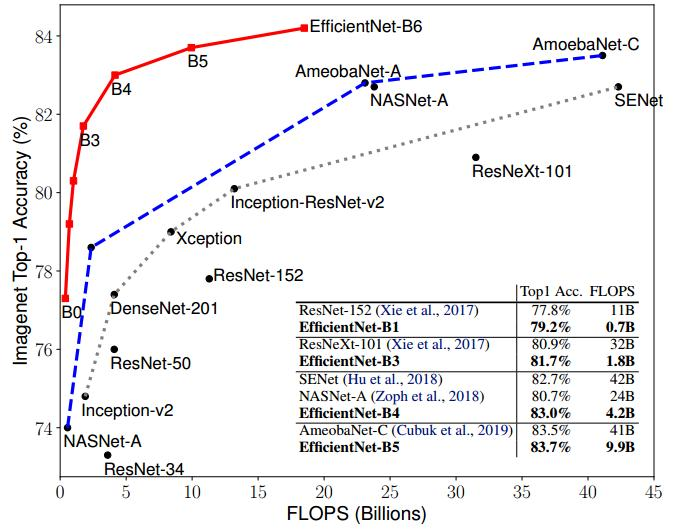

2.   EfficientNet Network Principle


>  Increasing the network parameters can improve accuracy (with enough data and without overfitting). For example, ResNet can be deepened from ResNet-18 to ResNet-200, and GPipe scaled up the baseline model four times to obtain 84.3% top-1 accuracy on the ImageNet dataset. There are three ways to increase the network parameters: depth, width, and resolution. Depth refers to the number of layers in the network, width refers to the number of channels convolved in the network (e.g., accuracy gain by increasing the number of channels in wide resnet), and resolution refers to the size of the input through the network (e.g., from 112x112 to 224x224.） Intuitively, these three scaling methods are not independent of each other. A deeper network should be used for images with the high resolution because a larger field of sensation is needed, and the network width should also be increased to obtain finer-grained features. Previously increasing the network parameters are scaling one of these three ways individually and not adjusting them simultaneously, and there is no study of the adjustment methods. efficientNet uses the compound scaling method, which uniformly scales the network depth, width, and resolution.


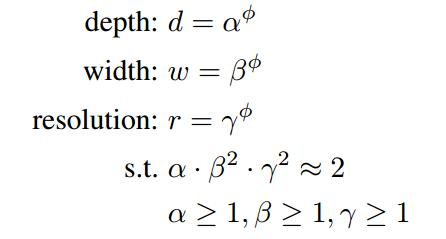



> As shown in the figure below, (a) is the baseline network, (b), (c), and (d) are the ways to make the network bigger by increasing width, depth, and resolution alone, and (e) is the way of compound scaling. 
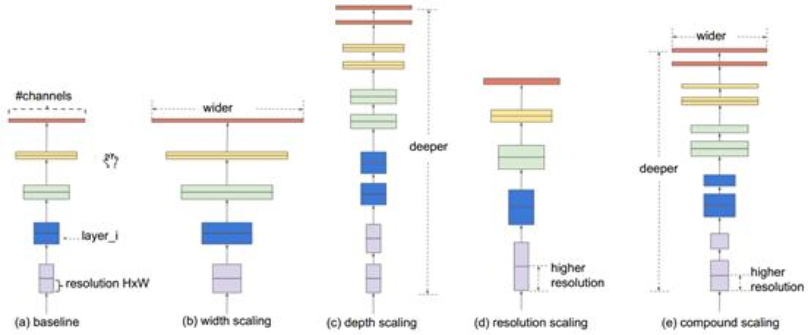

> The base network in EfficientNet is a similar approach to MNAS (the only difference is that the target is changed from hardware latency to FLOPS). After using compound scaling, the results are very significant, achieving a multiplicative improvement in both the number of different parameters and the amount of computation. In addition, the authors, to verify the gain of compound scaling alone, the base network does not use the results of MNAS network structure search, and directly scaling using MobileNets and ResNet as the base, the results show a 0.6~1.4% improvement in Top-1 Acc with close FLOPS. Finally, EfficientNet also has a 5~6 times improvement in latency relative to ResNet/GPipe.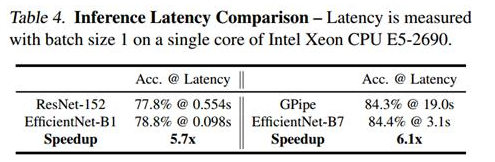

3.   Conclusion


> In general, the biggest contribution of EfficientNet is compound scaling, which guides us to increase the depth, width and resolution simultaneously when designing networks, especially for larger networks.













##Write code





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Model
from keras.applications.efficientnet import preprocess_input



In [3]:
train_data_dir = '/content/drive/MyDrive/FinalProject/archive/Garbage classification/Garbage classification'
img_width = 224
img_height = 224
batch_size = 32

# Augmentation data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,        
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    validation_split=0.1
    )
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Use flow_from_directory to train on batch, class_mode = categorical because have 6 classes
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=19
    ) 

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=19
    )


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [4]:
# We use model EfficientNetB0
pre_train_model = EfficientNetB0(
      include_top = False,
      weights = "imagenet",
      pooling='avg',
      input_shape = (img_width, img_height, 3)      
)

16719872/16705208 [==============================] - 0s 0us/step


In [5]:
pre_train_model.trainable = False
last_output = pre_train_model.output

In [6]:
from keras.layers import Dense, BatchNormalization, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from keras.layers.advanced_activations import PReLU, LeakyReLU

In [7]:
x = Flatten()(last_output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

In [8]:
# Define optimizer, learning rate and loss function
model = Model(pre_train_model.input, output)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['acc'])

In [9]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [10]:
myCallbacks = [
    keras.callbacks.EarlyStopping(monitor='val_acc',patience=30),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/FinalProject/EfficientNet/logs/efficientNet/efficientNet_{epoch:02d}_{val_acc:.2f}.h5',
                                    monitor='val_acc',mode='max',save_best_only=True, save_freq='epoch')    
]

In [11]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_validation = validation_generator.n//validation_generator.batch_size

history = model.fit(
      train_generator,
      steps_per_epoch = step_size_train,
      epochs = 60, #change it
      shuffle=False,
      verbose = 1,
      validation_data = validation_generator,
      validation_steps = step_size_validation,
      callbacks= myCallbacks
      )

Epoch 1/60
71/71 [==============================] - ETA: 0s - loss: 1.0933 - acc: 0.5902

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


71/71 [==============================] - 496s 7s/step - loss: 1.0933 - acc: 0.5902 - val_loss: 0.9093 - val_acc: 0.7857
Epoch 2/60
71/71 [==============================] - 66s 929ms/step - loss: 0.6278 - acc: 0.7808 - val_loss: 0.6154 - val_acc: 0.8348
Epoch 3/60
71/71 [==============================] - 65s 915ms/step - loss: 0.5082 - acc: 0.8121 - val_loss: 0.4758 - val_acc: 0.8348
Epoch 4/60
71/71 [==============================] - 65s 914ms/step - loss: 0.4615 - acc: 0.8319 - val_loss: 0.4210 - val_acc: 0.8348
Epoch 5/60
71/71 [==============================] - 66s 922ms/step - loss: 0.4288 - acc: 0.8429 - val_loss: 0.3654 - val_acc: 0.8705
Epoch 6/60
71/71 [==============================] - 65s 915ms/step - loss: 0.3919 - acc: 0.8561 - val_loss: 0.3451 - val_acc: 0.8705
Epoch 7/60
71/71 [==============================] - 67s 939ms/step - loss: 0.3648 - acc: 0.8816 - val_loss: 0.3324 - val_acc: 0.8839
Epoch 8/60
71/71 [==============================] - 66s 933ms/step - loss: 0.3424 

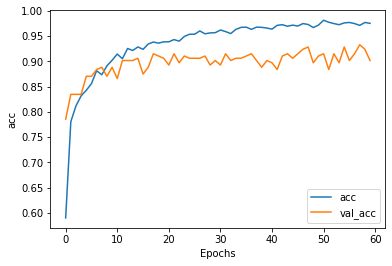

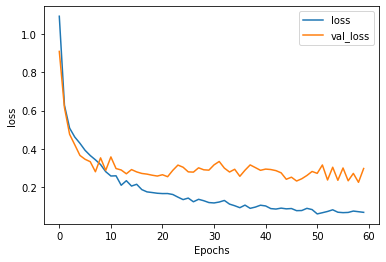

In [12]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'acc')
plot_graphs(history,'loss')

In [13]:
#test model
loss= model.evaluate(validation_generator, steps=validation_generator.n)
print("loss test: {:.2f}\n".format(loss[0]), "\raccuracy test: {:0.2f}".format(loss[1]))

251/251 [==============================] - 7s 24ms/step - loss: 0.2616 - acc: 0.9243
loss test: 0.26
accuracy test: 0.92


In [14]:
class_labels = list(validation_generator.class_indices.keys()) 
class_labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

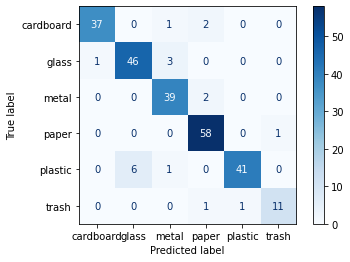

In [15]:
from sklearn import metrics
#Confution Matrix
Y_pred = model.predict(validation_generator, step_size_validation // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = metrics.confusion_matrix(validation_generator.classes, y_pred)

class_labels = list(validation_generator.class_indices.keys()) 
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
results = model.predict(validation_generator, steps=validation_generator.n)
predicted_classes = np.argmax(results, axis=1)
# print(predicted_classes)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   cardboard       0.97      0.93      0.95        40
       glass       0.87      0.92      0.89        50
       metal       0.88      0.90      0.89        41
       paper       0.89      0.98      0.94        59
     plastic       1.00      0.85      0.92        48
       trash       1.00      0.92      0.96        13

    accuracy                           0.92       251
   macro avg       0.94      0.92      0.93       251
weighted avg       0.92      0.92      0.92       251



Predicted class:  cardboard


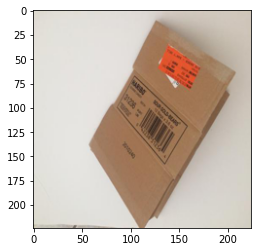

In [17]:
from matplotlib.pyplot import imshow
from PIL import Image

image_path="/content/drive/MyDrive/FinalProject/data/validation/cardboard/cardboard131.jpg"
im = Image.open(image_path).resize((224,224))
imshow(np.asarray(im))
# im = im.convert('RGB')
im = np.array(im)
im = im.reshape(-1,224,224,3)
result = model.predict(im)  
predicted_class_indices=np.argmax(result,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print("Predicted class: ",predictions[0])